# Modeling multicomponent rejection with nanofiltration
- Part 1: how to build, initialize, simulate, and optimize a flowsheet using the coded interface. This will be demonstrated with a nanofiltration (NF) unit model based on the Donnan Steric Pore Model with Dielectric Exclusion (DSPM-DE).


# Part 1: Build, setup, simulate, and optimize the NF DSPM-DE unit model

<center><img src="nf_ui.png" width="730" height="340"></center>

<center><img src="nf_dspmde_transport_mechanisms.png" width="750" height="510"></center>
Image source: <a href="https://doi.org/10.1016/j.desal.2017.07.020">Roy et al., 2017</a>


## Step 1: Import libraries from Pyomo, IDAES, and WaterTAP.

### Import some essentials from Pyomo and IDAES:

In [1]:
# Imports from Pyomo
from pyomo.environ import (
    ConcreteModel,
    Constraint,
    Objective,
    Var,
    value,
    units as pyunits,
    assert_optimal_termination,
    check_optimal_termination,
    TransformationFactory,
    NonNegativeReals,
)
from pyomo.network import Arc

# Imports from IDAES:
# Import flowsheet block from IDAES core
from idaes.core import FlowsheetBlock

# Import propagate_state to initialize state variables between units
from idaes.core.util.initialization import propagate_state

# Import function to get default solver
from watertap.core.solvers import get_solver

# Import function to check degrees of freedom
from idaes.core.util.model_statistics import degrees_of_freedom

# Import utility function for calculating scaling factors
from idaes.core.util.scaling import (
    calculate_scaling_factors,
    set_scaling_factor,
    constraint_scaling_transform,
)

# Import IDAES units
from idaes.models.unit_models import Feed, Product

### WaterTAP Imports: 
* multicomponent property model
* pump
* NF DSPM-DE unit model
* configuration options, which can be used to change underlying model assumptions

In [2]:
# Imports from WaterTAP
# Import MultiComponent Aqueous Solution property model
from watertap.property_models.multicomp_aq_sol_prop_pack import (
    MCASParameterBlock,
    ActivityCoefficientModel,
)

# Import pump model
from watertap.unit_models.pressure_changer import Pump

# Import NF DSPM-DE model
from watertap.unit_models.nanofiltration_DSPMDE_0D import (
    NanofiltrationDSPMDE0D,
    MassTransferCoefficient,
    ConcentrationPolarizationType,
)

### Imports for costing:

In [3]:
from idaes.core import UnitModelCostingBlock
from watertap.costing import WaterTAPCosting

## Step 2: Start building the components needed in the NF DSPM-DE flowsheet.

### Create a Pyomo concrete model and flowsheet 

In [4]:
m = ConcreteModel()
m.fs = FlowsheetBlock(dynamic=False)

### Set up solute/solution properties required by the DSPM-DE model.
* Define a list of solutes
* For each solute, provide data on
    * Diffusivity
    * Molecular weight
    * Stokes' radius
    * Charge
* Choose ideal solution (activity coefficients=1) or Davies model

In [5]:
property_kwds = {
    "solute_list": [
        "Ca_2+",
        "SO4_2-",
        "HCO3_-",
        "Na_+",
        "Cl_-",
    ],
    "diffusivity_data": {
        ("Liq", "Ca_2+"): 9.2e-10,
        ("Liq", "SO4_2-"): 1.06e-9,
        ("Liq", "HCO3_-"): 1.19e-9,
        ("Liq", "Na_+"): 1.33e-9,
        ("Liq", "Cl_-"): 2.03e-9,
    },
    "mw_data": {
        "H2O": 18e-3,
        "Ca_2+": 40e-3,
        "HCO3_-": 61.0168e-3,
        "SO4_2-": 96e-3,
        "Na_+": 23e-3,
        "Cl_-": 35e-3,
    },
    "stokes_radius_data": {
        "Ca_2+": 0.309e-9,
        "HCO3_-": 2.06e-10,
        "SO4_2-": 0.230e-9,
        "Cl_-": 0.121e-9,
        "Na_+": 0.184e-9,
    },
    "charge": {
        "Ca_2+": 2,
        "HCO3_-": -1,
        "SO4_2-": -2,
        "Na_+": 1,
        "Cl_-": -1,
    },
    "activity_coefficient_model": ActivityCoefficientModel.davies,
}

### Create an instance of WaterTAP's multicomponent aqueous solution (MCAS) property model

In [6]:
m.fs.properties = MCASParameterBlock(**property_kwds)

### Add a feed, product, and disposal blocks
* Feed for inlet composition
* Product for NF permeate
* Disposal for NF concentrate

In [7]:
m.fs.feed = Feed(property_package=m.fs.properties)
m.fs.product = Product(property_package=m.fs.properties)
m.fs.disposal = Product(property_package=m.fs.properties)

### Add a pump and an NF DSPM-DE unit to the flowsheet.

In [8]:
m.fs.pump = Pump(property_package=m.fs.properties)
m.fs.nf = NanofiltrationDSPMDE0D(
    property_package=m.fs.properties,
    concentration_polarization_type=ConcentrationPolarizationType.calculated,
    mass_transfer_coefficient=MassTransferCoefficient.spiral_wound,
    has_pressure_change=True,
)

### Connect units within the flowsheet. 

In [9]:
m.fs.feed_to_pump = Arc(source=m.fs.feed.outlet, destination=m.fs.pump.inlet)

m.fs.pump_to_nf = Arc(source=m.fs.pump.outlet, destination=m.fs.nf.inlet)

m.fs.nf_to_product = Arc(source=m.fs.nf.permeate, destination=m.fs.product.inlet)

m.fs.nf_to_disposal = Arc(source=m.fs.nf.retentate, destination=m.fs.disposal.inlet)

TransformationFactory("network.expand_arcs").apply_to(m)

## Step 3: Specify values for system variables.

### Fix inlet state variables 
* mole flow rates of each component
* temperature
* pressure

#### From mass fractions of each ion in solution, calculate molar flow rates--the state variables of our property model

In [10]:
# m.fs.feed.properties[0].temperature.fix(298.15)
# m.fs.feed.properties[0].pressure.fix(101325)

# feed_mass_frac = {
#     "Ca_2+": 4.0034374454637006e-04,
#     "HCO3_-": 0.00022696833343821863,
#     "SO4_2-": 0.00020497140244420624,
#     "Cl_-": 0.0004559124032433401,
#     "Na_+": 0.00043333830389924205,
# }
# H2O_mass_frac = 1 - sum(x for x in feed_mass_frac.values())

# # scale molar flowrate variables
# m.fs.properties.set_default_scaling(
#     "flow_mol_phase_comp", 1 / 0.01, index=("Liq", "Ca_2+")
# )
# m.fs.properties.set_default_scaling(
#     "flow_mol_phase_comp", 1 / 0.002, index=("Liq", "SO4_2-")
# )
# m.fs.properties.set_default_scaling(
#     "flow_mol_phase_comp", 1 / 0.0037, index=("Liq", "HCO3_-")
# )
# m.fs.properties.set_default_scaling(
#     "flow_mol_phase_comp", 1 / 0.013, index=("Liq", "Cl_-")
# )
# m.fs.properties.set_default_scaling(
#     "flow_mol_phase_comp", 1 / 0.018, index=("Liq", "Na_+")
# )
# m.fs.properties.set_default_scaling("flow_mol_phase_comp", 1 / 55, index=("Liq", "H2O"))

# m.fs.feed.properties[0].mass_frac_phase_comp
# m.fs.feed.properties[0].conc_mol_phase_comp
# m.fs.feed.properties[0].conc_mass_phase_comp
# m.fs.feed.properties[0].flow_vol_phase
# calculate_scaling_factors(m.fs.feed.properties[0])
# m.fs.feed.properties.calculate_state(
#     var_args={
#         ("mass_frac_phase_comp", ("Liq", "Ca_2+")): 4.0034374454637006e-04,
#         ("mass_frac_phase_comp", ("Liq", "HCO3_-")): 0.00022696833343821863,
#         ("mass_frac_phase_comp", ("Liq", "SO4_2-")): 0.00020497140244420624,
#         ("mass_frac_phase_comp", ("Liq", "Cl_-")): 0.0004559124032433401,
#         ("mass_frac_phase_comp", ("Liq", "Na_+")): 0.00043333830389924205,
#         ("flow_vol_phase", "Liq"): 1e-3,
#     },
#     hold_state=True,
# )
# m.fs.feed.display()

In [11]:
# set feed T and P
m.fs.feed.properties[0].temperature.fix(298.15)
m.fs.feed.properties[0].pressure.fix(101325)

# mass fractions for solutes (H2O inferred)
feed_mass_frac = {
    "Ca_2+": 4.0034374454637006e-04,
    "HCO3_-": 0.00022696833343821863,
    "SO4_2-": 0.00020497140244420624,
    "Cl_-": 0.0004559124032433401,
    "Na_+": 0.00043333830389924205,
}
H2O_mass_frac = 1 - sum(feed_mass_frac.values())

# build state inputs and fix feed volumetric flow
state_args = {
    ("mass_frac_phase_comp", ("Liq", comp)): val for comp, val in feed_mass_frac.items()
}
# state_args[("mass_frac_phase_comp", ("Liq", "H2O"))] = H2O_mass_frac
state_args[("flow_vol_phase", "Liq")] = 1e-3  # m3/s

m.fs.feed.properties.calculate_state(var_args=state_args, hold_state=True)
m.fs.feed.display()

2025-12-05 10:28:38 [WARNING] idaes.watertap.property_models.multicomp_aq_sol_prop_pack: While using the calculate_state method on fs.feed.properties[0.0], variable mass_frac_phase_comp was provided as an argument in var_args, but it does not have a scaling factor. This suggests that the calculate_scaling_factor method has not been used or the variable was created on demand after the scaling factors were calculated. It is recommended to touch all relevant variables (i.e. call them or set an initial value) before using the calculate_scaling_factor method.
2025-12-05 10:28:38 [WARNING] idaes.watertap.property_models.multicomp_aq_sol_prop_pack: While using the calculate_state method on fs.feed.properties[0.0], variable mass_frac_phase_comp was provided as an argument in var_args, but it does not have a scaling factor. This suggests that the calculate_scaling_factor method has not been used or the variable was created on demand after the scaling factors were calculated. It is recommended t

In [12]:
m.fs.feed.properties[0].conc_mass_phase_comp.display()

conc_mass_phase_comp : Mass concentration
    Size=6, Index=fs.properties.phase_list*fs.properties.component_list, Units=kg/m**3
    Key               : Lower : Value : Upper  : Fixed : Stale : Domain
     ('Liq', 'Ca_2+') :     0 :    10 : 2000.0 : False : False :  Reals
      ('Liq', 'Cl_-') :     0 :    10 : 2000.0 : False : False :  Reals
       ('Liq', 'H2O') :     0 :    10 : 2000.0 : False : False :  Reals
    ('Liq', 'HCO3_-') :     0 :    10 : 2000.0 : False : False :  Reals
      ('Liq', 'Na_+') :     0 :    10 : 2000.0 : False : False :  Reals
    ('Liq', 'SO4_2-') :     0 :    10 : 2000.0 : False : False :  Reals


### Display feed composition

In [13]:
# print("Mole flow rates (mole/s)")
# [
#     print(f"{j} = {value(m.fs.feed.properties[0].flow_mol_phase_comp['Liq', j])}")
#     for j in m.fs.properties.component_list
# ]
# print("\nMolarities (mol/m3)")
# [
#     print(f"{j} = {value(m.fs.feed.properties[0].conc_mol_phase_comp['Liq', j])}")
#     for j in m.fs.properties.component_list
# ]
print("\nMass fractions (ppm)")
[
    print(f"{j} = {value(m.fs.feed.properties[0].mass_frac_phase_comp['Liq', j])*1e6}")
    for j in m.fs.properties.solute_set
];


Mass fractions (ppm)
Ca_2+ = 400.3437445463701
SO4_2- = 204.97140244420623
HCO3_- = 226.96833343821862
Na_+ = 433.3383038992421
Cl_- = 455.91240324334007


### Use assert_electroneutrality method from property model to ensure the ion concentrations provided obey electroneutrality condition

In [14]:
m.fs.feed.properties[0].assert_electroneutrality(
    defined_state=True, adjust_by_ion="Cl_-"
)

Cl_- adjusted: fs.feed.properties[0.0].flow_mol_phase_comp['Liq',Cl_-] was adjusted from 0.013026068655797767 and fixed to 0.030867977589658056. Electroneutrality satisfied for fs.feed.properties[0.0]. Balance Result = 0.0


### Display feed composition again, after adjustment to achieve electroneutrality

In [15]:
# print("Mole flow rates (mole/s)")
# [
#     print(f"{j} = {value(m.fs.feed.properties[0].flow_mol_phase_comp['Liq', j])}")
#     for j in m.fs.properties.component_list
# ]
# print("\nMolarities (mol/m3)")
# [
#     print(f"{j} = {value(m.fs.feed.properties[0].conc_mol_phase_comp['Liq', j])}")
#     for j in m.fs.properties.component_list
# ]
print("\nMass fractions (ppm)")
[
    print(f"{j} = {value(m.fs.feed.properties[0].mass_frac_phase_comp['Liq', j])*1e6}")
    for j in m.fs.properties.solute_set
];


Mass fractions (ppm)
Ca_2+ = 400.09389910970003
SO4_2- = 204.8434843360484
HCO3_- = 226.82668756423962
Na_+ = 433.06786731977576
Cl_- = 1079.7049762831407


### Fix pump variables for initial simulation.
* Pump efficiency
* Pump discharge pressure

In [16]:
m.fs.pump.efficiency_pump[0].fix(0.75)
m.fs.pump.outlet.pressure[0].fix(3e5)

# To check units of pressure:
# print(str(m.fs.pump.outlet.pressure[0]._units))

### Fix the membrane variables that are typically fixed for the DSPM-DE model.
* membrane pore radius
* effective membrane thickness
* membrane charge density
* pore dielectric constant


In [17]:
m.fs.nf.radius_pore.fix(0.5e-9)
m.fs.nf.membrane_thickness_effective.fix(8.6e-07)
m.fs.nf.membrane_charge_density.fix(-680)
m.fs.nf.dielectric_constant_pore.fix(41.3)

# Fix final permeate pressure to be ~atmospheric
m.fs.nf.mixed_permeate[0].pressure.fix(101325)
m.fs.nf.deltaP.fix(0 * pyunits.bar)

m.fs.nf.spacer_porosity.fix(0.85)
m.fs.nf.channel_height.fix(1e-3)
m.fs.nf.velocity[0, 0].fix(0.25)
m.fs.nf.area.fix(50)

# Fix additional variables for calculating mass transfer coefficient with spiral wound correlation
m.fs.nf.spacer_mixing_efficiency.fix()
m.fs.nf.spacer_mixing_length.fix()

# Create on-demand properties, total hardness for the NF permeate and brine, as well as mass fraction in NF permeate, by "touching" them
m.fs.product.properties[0].total_hardness
m.fs.product.properties[0].mass_frac_phase_comp
m.fs.disposal.properties[0].total_hardness;

## Step 4: Calculate scaling factors for variables.
We can aim for scaling factors that are approximately the inverse of variable values. 
For example, if we know pressure is typically around 1e6 Pa, we could apply a scaling factor of 1e-6 to scale the variable value of pressure to 1.


In [18]:
m.fs.properties.set_default_scaling(
    "flow_mol_phase_comp", 1 / 0.01, index=("Liq", "Ca_2+")
)
m.fs.properties.set_default_scaling(
    "flow_mol_phase_comp", 1 / 0.002, index=("Liq", "SO4_2-")
)
m.fs.properties.set_default_scaling(
    "flow_mol_phase_comp", 1 / 0.0037, index=("Liq", "HCO3_-")
)
m.fs.properties.set_default_scaling(
    "flow_mol_phase_comp", 1 / 0.013, index=("Liq", "Cl_-")
)
m.fs.properties.set_default_scaling(
    "flow_mol_phase_comp", 1 / 0.018, index=("Liq", "Na_+")
)
m.fs.properties.set_default_scaling("flow_mol_phase_comp", 1 / 55, index=("Liq", "H2O"))

set_scaling_factor(m.fs.nf.area, 0.1)

calculate_scaling_factors(m);

2025-12-05 10:28:39 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.pump.control_volume.work


## Step 5: Initialize the model.

In [19]:
m.fs.feed.initialize()

propagate_state(m.fs.feed_to_pump)
m.fs.pump.initialize()

propagate_state(m.fs.pump_to_nf)
m.fs.nf.initialize()

propagate_state(m.fs.nf_to_product)
propagate_state(m.fs.nf_to_disposal)
m.fs.product.initialize()

2025-12-05 10:28:40 [INFO] idaes.init.fs.feed: Initialization Complete.
2025-12-05 10:28:40 [INFO] idaes.init.fs.pump.control_volume: Initialization Complete
component keys that are not exported as part of the NL file.  Skipping.
that are not Var, Constraint, Objective, or the model.  Skipping.
2025-12-05 10:28:40 [INFO] idaes.init.fs.pump: Initialization Complete: optimal - Optimal Solution Found
2025-12-05 10:28:43 [INFO] idaes.init.fs.nf: Initialization Complete: optimal - Optimal Solution Found
2025-12-05 10:28:43 [INFO] idaes.init.fs.product: Initialization Complete.


In [20]:
m.fs.feed.report()
m.fs.pump.report()
m.fs.nf.report()


Unit : fs.feed                                                             Time: 0.0
------------------------------------------------------------------------------------
    Stream Table
                                              Units        Outlet  
    flow_mol_phase_comp ('Liq', 'H2O')     mole / second     55.460
    flow_mol_phase_comp ('Liq', 'Ca_2+')   mole / second   0.010009
    flow_mol_phase_comp ('Liq', 'SO4_2-')  mole / second  0.0021351
    flow_mol_phase_comp ('Liq', 'HCO3_-')  mole / second  0.0037198
    flow_mol_phase_comp ('Liq', 'Na_+')    mole / second   0.018841
    flow_mol_phase_comp ('Liq', 'Cl_-')    mole / second   0.030868
    temperature                                   kelvin     298.15
    pressure                                      pascal 1.0132e+05

Unit : fs.pump                                                             Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Var

### Display feed pressure, membrane area, and rejection rates after initializing the flowsheet.

In [21]:
m.fs.nf.inlet.pressure[0].display()
m.fs.nf.area.display()
m.fs.nf.rejection_observed_phase_comp.display()
m.fs.nf.rejection_intrinsic_phase_comp.display()

pressure : State pressure
    Size=1, Index=None, Units=Pa
    Key  : Lower    : Value    : Upper : Fixed : Stale : Domain
    None : 100000.0 : 300000.0 :  None : False :  True : NonNegativeReals
area : Membrane area
    Size=1, Index=None, Units=m**2
    Key  : Lower : Value : Upper  : Fixed : Stale : Domain
    None :     0 :    50 : 1000.0 :  True :  True : NonNegativeReals
rejection_observed_phase_comp : Size=5
    Key                    : Value
     (0.0, 'Liq', 'Ca_2+') : 0.8463798508169414
      (0.0, 'Liq', 'Cl_-') : 0.6833627595629908
    (0.0, 'Liq', 'HCO3_-') : 0.7783867642905179
      (0.0, 'Liq', 'Na_+') : 0.6006872406672987
    (0.0, 'Liq', 'SO4_2-') :  0.999973799282092
rejection_intrinsic_phase_comp : Intrinsic solute rejection
    Size=5, Index=fs._time*fs.properties.phase_list*fs.nf.solute_set, Units=dimensionless
    Key                    : Lower  : Value              : Upper : Fixed : Stale : Domain
     (0.0, 'Liq', 'Ca_2+') : -1.001 : 0.8830001436904562 : 1.001 

## Step 6: Setup a solver and run a simulation.

### The degrees of freedom should be 0 for a simulation.
Check that degrees of freedom = 0 before attempting simulation. This means that the performance of the flowsheet is completely determined by the system variables that were fixed above.

In [22]:
print(f"Degrees of freedom = {degrees_of_freedom(m)}")
assert degrees_of_freedom(m) == 0

Degrees of freedom = 0


### Setup solver

In [23]:
solver = get_solver()

### Run simulation


In [24]:
simulation_results = solver.solve(m)
assert_optimal_termination(simulation_results)

### Display feed pressure, membrane area, rejection rates, and water flux after simulation.

In [25]:
m.fs.pump.outlet.pressure[0].display()
m.fs.nf.area.display()
m.fs.nf.rejection_observed_phase_comp.display()
m.fs.nf.rejection_intrinsic_phase_comp.display()
print(
    f"\nAverage volumetric water flux={value(pyunits.convert(m.fs.nf.flux_vol_water_avg[0],to_units=pyunits.L/pyunits.m**2/pyunits.hour))} LMH"
)

pressure : State pressure
    Size=1, Index=None, Units=Pa
    Key  : Lower    : Value    : Upper : Fixed : Stale : Domain
    None : 100000.0 : 300000.0 :  None :  True :  True : NonNegativeReals
area : Membrane area
    Size=1, Index=None, Units=m**2
    Key  : Lower : Value : Upper  : Fixed : Stale : Domain
    None :     0 :    50 : 1000.0 :  True :  True : NonNegativeReals
rejection_observed_phase_comp : Size=5
    Key                    : Value
     (0.0, 'Liq', 'Ca_2+') : 0.8463798231019666
      (0.0, 'Liq', 'Cl_-') : 0.6833627786342966
    (0.0, 'Liq', 'HCO3_-') : 0.7783867806294509
      (0.0, 'Liq', 'Na_+') : 0.6006871957896589
    (0.0, 'Liq', 'SO4_2-') : 0.9999731960766313
rejection_intrinsic_phase_comp : Intrinsic solute rejection
    Size=5, Index=fs._time*fs.properties.phase_list*fs.nf.solute_set, Units=dimensionless
    Key                    : Lower  : Value              : Upper : Fixed : Stale : Domain
     (0.0, 'Liq', 'Ca_2+') : -1.001 : 0.8830001226657109 : 1.001 

### Sweep across pressure and plot rejection rates 

In [26]:
import numpy as np

area = []
pressure = []
ca_rej = []
hco3_rej = []
na_rej = []
cl_rej = []
so4_rej = []
recovery = []
water_flux = []


m.fs.nf.area.setub(None)
# for r in np.arange(0.05,1,.10):
for p in np.arange(2e5, 11e5, 1e5):
    m.fs.pump.outlet.pressure.fix(p)
    assert degrees_of_freedom(m) == 0
    optimization_results = solver.solve(m, tee=False)
    try:
        assert_optimal_termination(optimization_results)
    except RuntimeError:
        optimization_results = solver.solve(m, tee=False)
        if not check_optimal_termination(optimization_results):
            continue
        else:
            pass
    area.append(value(m.fs.nf.area))
    pressure.append(value(m.fs.nf.inlet.pressure[0]))
    ca_rej.append(value(m.fs.nf.rejection_intrinsic_phase_comp[0, "Liq", "Ca_2+"]))
    hco3_rej.append(value(m.fs.nf.rejection_intrinsic_phase_comp[0, "Liq", "HCO3_-"]))
    na_rej.append(value(m.fs.nf.rejection_intrinsic_phase_comp[0, "Liq", "Na_+"]))
    cl_rej.append(value(m.fs.nf.rejection_intrinsic_phase_comp[0, "Liq", "Cl_-"]))
    so4_rej.append(value(m.fs.nf.rejection_intrinsic_phase_comp[0, "Liq", "SO4_2-"]))
    recovery.append(value(m.fs.nf.recovery_vol_phase[0, "Liq"]))
    water_flux.append(value(m.fs.nf.flux_vol_water_avg[0] * 3.6e6))

### Plot Intrinsic Rejection vs. Recovery Rate

Text(0, 0.5, 'Intrinsic Rejection (-)')

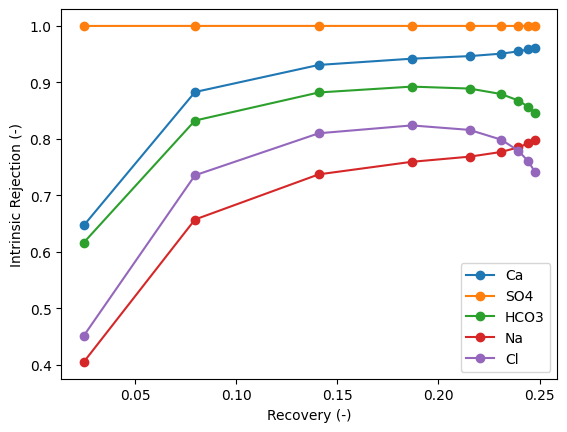

In [27]:
import matplotlib.pyplot as plt

plt.plot(recovery, ca_rej, "-o")
plt.plot(recovery, so4_rej, "-o")
plt.plot(recovery, hco3_rej, "-o")
plt.plot(recovery, na_rej, "-o")
plt.plot(recovery, cl_rej, "-o")
plt.legend(["Ca", "SO4", "HCO3", "Na", "Cl"])
plt.xlabel("Recovery (-)")
plt.ylabel("Intrinsic Rejection (-)")

### Plot Intrinsic Rejection vs. Pressure

Text(0, 0.5, 'Intrinsic Rejection (-)')

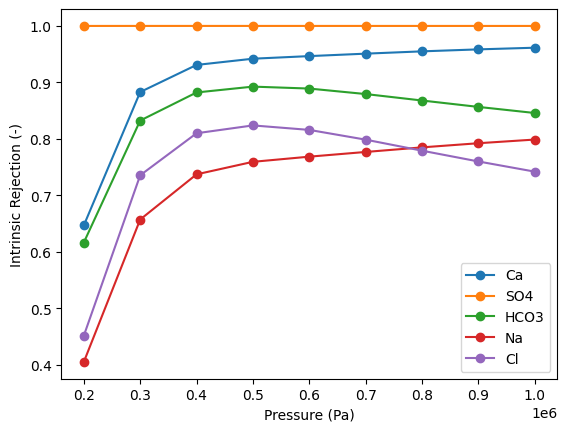

In [28]:
plt.plot(pressure, ca_rej, "-o")
plt.plot(pressure, so4_rej, "-o")
plt.plot(pressure, hco3_rej, "-o")
plt.plot(pressure, na_rej, "-o")
plt.plot(pressure, cl_rej, "-o")
plt.legend(["Ca", "SO4", "HCO3", "Na", "Cl"])
plt.xlabel("Pressure (Pa)")
plt.ylabel("Intrinsic Rejection (-)")

### Plot Intrinsic Rejection vs. Average Water Flux

Text(0, 0.5, 'Intrinsic Rejection (-)')

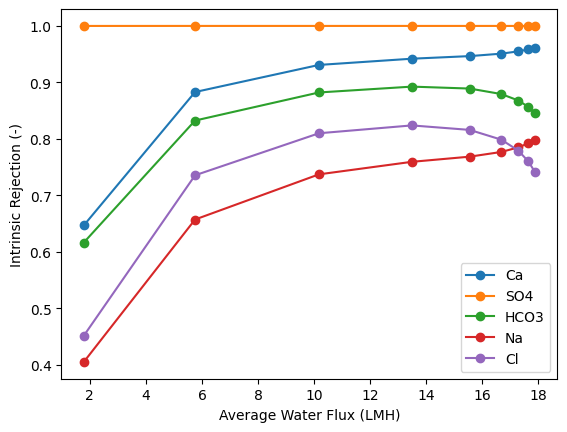

In [29]:
plt.plot(water_flux, ca_rej, "-o")
plt.plot(water_flux, so4_rej, "-o")
plt.plot(water_flux, hco3_rej, "-o")
plt.plot(water_flux, na_rej, "-o")
plt.plot(water_flux, cl_rej, "-o")
plt.legend(["Ca", "SO4", "HCO3", "Na", "Cl"])
plt.xlabel("Average Water Flux (LMH)")
plt.ylabel("Intrinsic Rejection (-)")

## Add costing to the flowsheet.

In [30]:
m.fs.costing = WaterTAPCosting()
m.fs.pump.costing = UnitModelCostingBlock(flowsheet_costing_block=m.fs.costing)
m.fs.nf.costing = UnitModelCostingBlock(flowsheet_costing_block=m.fs.costing)

- m.fs.costing.register_flow_type("disposal", m.fs.costing.disposal_cost)
    - Declares a new named flow category ("disposal") in the WaterTAP costing block and tells the costing object which variable represents the unit cost for that category (here m.fs.costing.disposal_cost, units USD_2018/m^3). In short: it creates a registry entry linking the flow type name to a per‑volume cost variable so the costing routines know how to price flows of that type.

- m.fs.costing.cost_flow(m.fs.disposal.properties[0].flow_vol_phase["Liq"], "disposal")
    - Applies the previously registered "disposal" cost to the specified volumetric flow variable. The method builds the internal cost expressions (multiplying the unit cost by the volumetric flow, handling unit conversion, and adding the resulting cost rate/annual cost into the flowsheet costing totals) so that when cost_process() (or other reporting) runs, disposal costs are included in operating/annual cost calculations.


In [ ]:
m.fs.costing.disposal_cost = Var(
    initialize=0.1,
    bounds=(0, None),
    doc="disposal cost",
    units=pyunits.USD_2018 / pyunits.m**3,
)
m.fs.costing.disposal_cost.fix()
m.fs.costing.register_flow_type("disposal", m.fs.costing.disposal_cost)
m.fs.costing.cost_flow(m.fs.disposal.properties[0].flow_vol_phase["Liq"], "disposal")

m.fs.costing.base_currency = pyunits.USD_2018
m.fs.costing.cost_process()

m.fs.costing.add_annual_water_production(m.fs.product.properties[0].flow_vol)
m.fs.costing.add_LCOW(m.fs.product.properties[0].flow_vol)
m.fs.costing.add_specific_energy_consumption(m.fs.product.properties[0].flow_vol)

In [32]:
m.fs.costing.aggregate_flow_costs.display()

aggregate_flow_costs : Size=2, Index=fs.costing.used_flows, Units=USD_2018/a
    Key         : Lower : Value : Upper : Fixed : Stale : Domain
       disposal :  None :  None :  None : False :  True :  Reals
    electricity :  None :  None :  None : False :  True :  Reals


### Initialize the costing block

In [33]:
m.fs.costing.initialize()

### Run simulation with costing included

In [34]:
simulation_with_cost_results = solver.solve(m)
assert_optimal_termination(simulation_with_cost_results)

### Check SEC and LCOW results without any optimization.

In [35]:
# Print pump pressure (in bar), membrane area, rejections, flux, SEC, and LCOW
print(f"Membrane area = {value(m.fs.nf.area):.4f} m^2")
print(
    f"Pump outlet pressure = {value(pyunits.convert(m.fs.pump.outlet.pressure[0], to_units=pyunits.bar)):.3f} bar"
)
print(f"Recovery (vol) = {value(m.fs.nf.recovery_vol_phase[0,'Liq'])*100:.2f} %")

# Specific energy consumption (try to present in kWh/m3 if units available)
try:
    sec_kwh_m3 = value(
        pyunits.convert(
            m.fs.costing.specific_energy_consumption,
            to_units=pyunits.kWh / pyunits.m**3,
        )
    )
    print(f"Specific energy consumption = {sec_kwh_m3:.6f} kWh/m^3")
except Exception:
    print(
        f"Specific energy consumption = {value(m.fs.costing.specific_energy_consumption)}"
    )

# LCOW in USD_2018/m^3
lcow_val = value(
    pyunits.convert(m.fs.costing.LCOW, to_units=pyunits.USD_2018 / pyunits.m**3)
)
print(f"LCOW = {lcow_val:.6f} USD_2018/m^3\n")

# Rejection rates per solute (observed vs intrinsic)
print("Rejection (observed vs intrinsic):")
for comp in m.fs.properties.solute_set:
    obs = value(m.fs.nf.rejection_observed_phase_comp[0, "Liq", comp])
    intr = value(m.fs.nf.rejection_intrinsic_phase_comp[0, "Liq", comp])
    print(f"  {comp:8s}: observed = {obs:.6f}, intrinsic = {intr:.6f}")

print(
    f"\nAverage volumetric water flux={value(pyunits.convert(m.fs.nf.flux_vol_water_avg[0],to_units=pyunits.L/pyunits.m**2/pyunits.hour))} LMH"
)

Membrane area = 50.0000 m^2
Pump outlet pressure = 10.000 bar
Recovery (vol) = 24.76 %
Specific energy consumption = 1.344452 kWh/m^3
LCOW = 303.320173 USD_2018/m^3

Rejection (observed vs intrinsic):
  Ca_2+   : observed = 0.573510, intrinsic = 0.961425
  SO4_2-  : observed = 0.997956, intrinsic = 0.999955
  HCO3_-  : observed = 0.359553, intrinsic = 0.845897
  Na_+    : observed = 0.485231, intrinsic = 0.798908
  Cl_-    : observed = 0.486693, intrinsic = 0.742135

Average volumetric water flux=17.872031176108145 LMH


## Step 7: Unfix variables, set variable bounds, and run optimization.

### Unfix membrane area and feed pressure.


In [36]:
m.fs.nf.area.unfix()  # membrane area (m^2)
m.fs.pump.outlet.pressure[0].unfix()  # feed pressure (Pa)

### Set lower and upper bounds for membrane area; set upper bound for NF inlet pressure.



In [37]:
m.fs.nf.area.setlb(1)
m.fs.nf.area.setub(None)
m.fs.nf.inlet.pressure[0].setub(40e5)

### Define objective function to minimize the specific energy consumption.


In [38]:
m.fs.sec_objective = Objective(expr=m.fs.costing.specific_energy_consumption)

### Add a constraint limiting the maximum hardness of the permeate.

In [39]:
m.fs.max_hardness = Var(
    initialize=250,
    domain=NonNegativeReals,
    units=pyunits.mg / pyunits.L,
    doc="Maximum total hardness as CaCO3",
)
m.fs.max_hardness.fix(0.5 * value(m.fs.feed.properties[0].total_hardness))

m.fs.max_hardness_constraint = Constraint(
    expr=m.fs.nf.mixed_permeate[0].total_hardness <= m.fs.max_hardness
)
# Scale the new constraint
set_scaling_factor(
    m.fs.nf.mixed_permeate[0].total_hardness,
    1 / value(m.fs.nf.mixed_permeate[0].total_hardness),
)
set_scaling_factor(m.fs.max_hardness, 1 / value(m.fs.max_hardness))
constraint_scaling_transform(m.fs.max_hardness_constraint, 1 / value(m.fs.max_hardness))

### The solver will optimize membrane area, inlet pressure, and recovery rate, while minimizing specific energy consumption. Let's check the degrees of freedom.

In [40]:
print(degrees_of_freedom(m))

2


### Solve the model, optimizing with 2 degrees of freedom

In [41]:
optimization_results = solver.solve(m)
assert_optimal_termination(optimization_results)

### Check SEC-optimal results for
* membrane area
* pump pressure
* recovery rate
* SEC
* LCOW
* rejection rates

In [42]:
m.fs.nf.area.display()

m.fs.pump.outlet.pressure.display()

m.fs.nf.recovery_vol_phase.display()

m.fs.costing.specific_energy_consumption.display()

m.fs.costing.LCOW.display()

m.fs.nf.rejection_observed_phase_comp.display()

m.fs.nf.rejection_intrinsic_phase_comp.display()

print(
    f"\nAverage volumetric water flux={value(pyunits.convert(m.fs.nf.flux_vol_water_avg[0],to_units=pyunits.L/pyunits.m**2/pyunits.hour))} LMH"
)

## Previous SEC and LCOW results from simulation:
# specific_energy_consumption : Size=1
#     Key  : Value
#     None : 1.3444516491470768
# LCOW : Levelized Cost of Water based on flow fs.product.properties[0.0].flow_vol
#     Size=1, Index=None, Units=USD_2018/m**3
#     Key  : Lower : Value              : Upper : Fixed : Stale : Domain
#     None :  None : 0.5316151578977553 :  None : False : False :  Reals

area : Membrane area
    Size=1, Index=None, Units=m**2
    Key  : Lower : Value              : Upper : Fixed : Stale : Domain
    None :     1 : 2354.4103034698464 :  None : False : False : NonNegativeReals
_pressure_outlet_ref : Size=1, Index=fs._time, ReferenceTo=fs.pump.control_volume.properties_out[...].component('pressure')
    Key : Lower    : Value              : Upper : Fixed : Stale : Domain
    0.0 : 100000.0 : 236480.08402306432 :  None : False : False : NonNegativeReals
recovery_vol_phase : Volumetric-based recovery
    Size=1, Index=fs._time*fs.properties.phase_list, Units=dimensionless
    Key          : Lower : Value             : Upper : Fixed : Stale : Domain
    (0.0, 'Liq') :     0 : 0.995425822179468 :     1 : False : False :  Reals
specific_energy_consumption : Size=1
    Key  : Value
    None : 0.05028746232186439
LCOW : Size=1
    Key  : Value
    None : 0.9395150288409106
rejection_observed_phase_comp : Size=5
    Key                    : Value
     (0.0, 'Liq'

### Add an objective function to minimize the LCOW and optimize again.

#### Deactivate the SEC objective first.

In [43]:
m.fs.sec_objective.deactivate()
m.fs.lcow_objective = Objective(expr=m.fs.costing.LCOW)

In [44]:
# Fix recovery rate to match the recovery rate of the SEC minimization result
m.fs.nf.recovery_vol_phase.fix()

optimization_results = solver.solve(m, tee=True)
assert_optimal_termination(optimization_results)

ipopt-watertap: ipopt with user variable scaling and IDAES jacobian constraint scaling
Ipopt 3.13.2: tol=1e-08
constr_viol_tol=1e-08
acceptable_constr_viol_tol=1e-08
bound_relax_factor=0.0
honor_original_bounds=no
nlp_scaling_method=user-scaling


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, 

### Check results after cost optimization.

In [45]:
print(f"Membrane area = {value(m.fs.nf.area):.4f} m^2")

print(
    f"Pump outlet pressure = {value(pyunits.convert(m.fs.pump.outlet.pressure[0], to_units=pyunits.bar)):.3f} bar"
)

print(f"Recovery (vol) = {value(m.fs.nf.recovery_vol_phase[0,'Liq'])*100:.2f} %")

# Specific energy consumption (present in kWh/m3 if possible)
try:
    sec_kwh_m3 = value(
        pyunits.convert(
            m.fs.costing.specific_energy_consumption,
            to_units=pyunits.kWh / pyunits.m**3,
        )
    )
    print(f"Specific energy consumption = {sec_kwh_m3:.6f} kWh/m^3")
except Exception:
    print(
        f"Specific energy consumption = {value(m.fs.costing.specific_energy_consumption)}"
    )

# LCOW in USD_2018/m^3
try:
    lcow_val = value(
        pyunits.convert(m.fs.costing.LCOW, to_units=pyunits.USD_2018 / pyunits.m**3)
    )
    print(f"LCOW = {lcow_val:.6f} USD_2018/m^3")
except Exception:
    print(f"LCOW = {value(m.fs.costing.LCOW)}")

print("\nRejection (observed vs intrinsic):")
for comp in m.fs.properties.solute_set:
    obs = value(m.fs.nf.rejection_observed_phase_comp[0, "Liq", comp])
    intr = value(m.fs.nf.rejection_intrinsic_phase_comp[0, "Liq", comp])
    print(f"  {comp:8s}: observed = {obs:.6f}, intrinsic = {intr:.6f}")

print(
    f"\nAverage volumetric water flux={value(pyunits.convert(m.fs.nf.flux_vol_water_avg[0],to_units=pyunits.L/pyunits.m**2/pyunits.hour))} LMH"
)

## Previous results from SEC optimization:
# specific_energy_consumption : Size=1
#     Key  : Value
#     None : 0.1707081027046537
# LCOW : Levelized Cost of Water based on flow fs.product.properties[0.0].flow_vol
#     Size=1, Index=None, Units=USD_2018/m**3
#     Key  : Lower : Value              : Upper : Fixed : Stale : Domain
#     None :  None : 0.2921494718570934 :  None : False : False :  Reals

## Previous results from simulation:
# specific_energy_consumption : Size=1
#     Key  : Value
#     None : 1.3444516491470768
# LCOW : Levelized Cost of Water based on flow fs.product.properties[0.0].flow_vol
#     Size=1, Index=None, Units=USD_2018/m**3
#     Key  : Lower : Value              : Upper : Fixed : Stale : Domain
#     None :  None : 0.5316151578977553 :  None : False : False :  Reals

Membrane area = 442.0085 m^2
Pump outlet pressure = 5.716 bar
Recovery (vol) = 99.54 %
Specific energy consumption = 0.174993 kWh/m^3
LCOW = 0.481533 USD_2018/m^3

Rejection (observed vs intrinsic):
  Ca_2+   : observed = 0.532217, intrinsic = 0.866201
  SO4_2-  : observed = 0.768093, intrinsic = 0.970365
  HCO3_-  : observed = 0.409466, intrinsic = 0.821111
  Na_+    : observed = 0.377188, intrinsic = 0.670171
  Cl_-    : observed = 0.419754, intrinsic = 0.700808

Average volumetric water flux=8.127444001753556 LMH


#### Quick TDS calcs


In [46]:
feed_tds = [
    value(
        sum(
            m.fs.feed.properties[0].mass_frac_phase_comp["Liq", j]
            for j in m.fs.properties.solute_set
        )
    )
]
perm_tds = [
    value(
        sum(
            m.fs.product.properties[0].mass_frac_phase_comp["Liq", j]
            for j in m.fs.properties.solute_set
        )
    )
]
print(f"TDS rejection = {100*(1-perm_tds[0]/feed_tds[0]):.1f}%")

TDS rejection = 46.1%


#### Print total hardness in feed, permeate, and brine.

In [47]:
feed_TH = value(m.fs.feed.properties[0].total_hardness)
brine_TH = value(m.fs.disposal.properties[0].total_hardness)
perm_TH = value(m.fs.product.properties[0].total_hardness)

print("TH rejection", 100 * (1 - perm_TH / feed_TH), "%")
print("Total hardness (mg/L as CaCO3):\n")
print("Feed:", feed_TH)
print("Brine:", brine_TH)
print("Permeate:", perm_TH)

TH rejection 53.22171351590417 %
Total hardness (mg/L as CaCO3):

Feed: 1001.1039517701024
Brine: 116949.27096216886
Permeate: 468.2992745626231


## Summary: 
### We covered how to build, scale, initialize, simulate and optimize a flowsheet, using the NF DSPM-DE as an example with costing.
### We also introduced the multicomponent aqueous solution (MCAS) property model, which allows specification of multicomponent solutions.

### A video walkthrough of this tutorial: https://youtu.be/iRFYC0IWO90 (begins at 6:37 and ends at 37:29)
<div class="alert alert-block alert-info">
The following video excerpt shows an example of running this model in the Graphical User Interface:

<b><a href="https://www.youtube.com/embed/iRFYC0IWO90?start=1695&end=2249">https://www.youtube.com/embed/iRFYC0IWO90?start=1695&end=2249</a>

<b>Note:</b>
MacOS is not fully supported or tested in WaterTAP at this time, so we recommend macOS users access the GUI through a Windows virtual machine to avoid potential flowsheet stability issues.
</div>

In [48]:
m.fs.costing.aggregate_flow_costs.display()

aggregate_flow_costs : Size=2, Index=fs.costing.used_flows, Units=USD_2018/a
    Key         : Lower : Value              : Upper : Fixed : Stale : Domain
       disposal :  None : 11016.314287966972 :  None : False : False :  Reals
    electricity :  None : 385.03809126173667 :  None : False : False :  Reals


In [52]:
m.fs.costing.pprint()

costing : Size=1, Index=None, Active=True
    2 Set Declarations
        flow_types : Size=1, Index=None, Ordered=Insertion
            Key  : Dimen : Domain : Size : Members
            None :     1 :    Any :    2 : {'electricity', 'disposal'}
        used_flows : Size=1, Index=None, Ordered=Insertion
            Key  : Dimen : Domain : Size : Members
            None :     1 :    Any :    2 : {'electricity', 'disposal'}

    19 Var Declarations
        TIC : Total Installed Cost (TIC)
            Size=1, Index=None, Units=dimensionless
            Key  : Lower : Value : Upper : Fixed : Stale : Domain
            None :  None :   2.0 :  None :  True :  True :  Reals
        TPEC : Total Purchased Equipment Cost (TPEC)
            Size=1, Index=None, Units=dimensionless
            Key  : Lower : Value             : Upper : Fixed : Stale : Domain
            None :  None : 4.121212121212121 :  None :  True :  True :  Reals
        aggregate_capital_cost : Size=1, Index=None, Units=USD